# Vehicle Detection
---

In [148]:
## Import

import matplotlib.image as mpimg
import numpy as np
import cv2

import matplotlib.pyplot as plt

import glob
import os
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

%matplotlib inline

## Define a Vehicle class 

In [149]:
# Define a class to receive the characteristics of each vehicle detection
# Objects defined as 'Vehicle' will be where multiple overlapping detections exist in the heatmap
class Vehicle():
    def __init__(self):
        self.detected = False # was the Vehicle detected in the last iteration?
        self.n_detection = 0 # Number of times this vehicle has been?
        self.n_nondetectections = 0 # Number of consecutive time this car has not been detected
        self.xpixels = None # Pixel x values of last detection
        self.ypixels = None # Pixel y values of last detection
        self.recent_xfitted = [] # x position of the last n fits of the bounding box
        self.bestx = None # average x position of the last n fits
        self.recent_yfitted = [] # y position of the last n fits of the bounding box
        self.besty = None # averagy y position of the last n fits
        self.recent_wfitted = [] # width of the last n fits of the bounding box
        self.bestw = None # average width of the last n fits
        self.recent_hfitted = [] # height of the last n fits of the bounding box
        self.besth = None # average height of the last n fits

In [150]:
# Define a class to record the heatmap of each frame
class Heatmaps():
    def __init__(self):
        self.heatmaps = []

## Define Functions

In [151]:
### Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
### Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [152]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
#             hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_img = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        #8) Append features to list
        img_features.append(hog_features)
#         print('hog_features: {}'.format(len(hog_features)))
#         print('spatial_features: {}'.format(len(spatial_features)))
#         print('hist_features: {}'.format(len(hist_features)))
        

    #9) Return concatenated array of features
    if vis==True:
        return np.concatenate(img_features), hog_img
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=False)
        #5) Scale extracted features to be fed to classifier
#         print('features.shape {}'.format(features.shape))
        test_features = scaler.transform(np.array(features).reshape(1, -1))
#         print('test_features.shape {}'.format(test_features.shape))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [153]:
# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [154]:
# Define a function to extract features from a frame
# This function is very similar to extract_features()
# just for a single frame image rather than list of images
def single_frame_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
#     return img_features
    return np.concatenate(img_features)


## Data Preparation

In [155]:
# Read in the files
cars_path = './data/vehicles'
notcars_path = './data/non-vehicles'
cars = [os.path.join(root, name)
                for root, dirs, files in os.walk(cars_path)
                for name in files
                if name.endswith(('.png', '.PNG'))]

notcars = [os.path.join(root, name)
                for root, dirs, files in os.walk(notcars_path)
                for name in files
                if name.endswith(('.png', '.PNG'))]

print('There are {} cars and {} notcars.'
      .format(len(cars), len(notcars)))

There are 8792 cars and 8968 notcars.


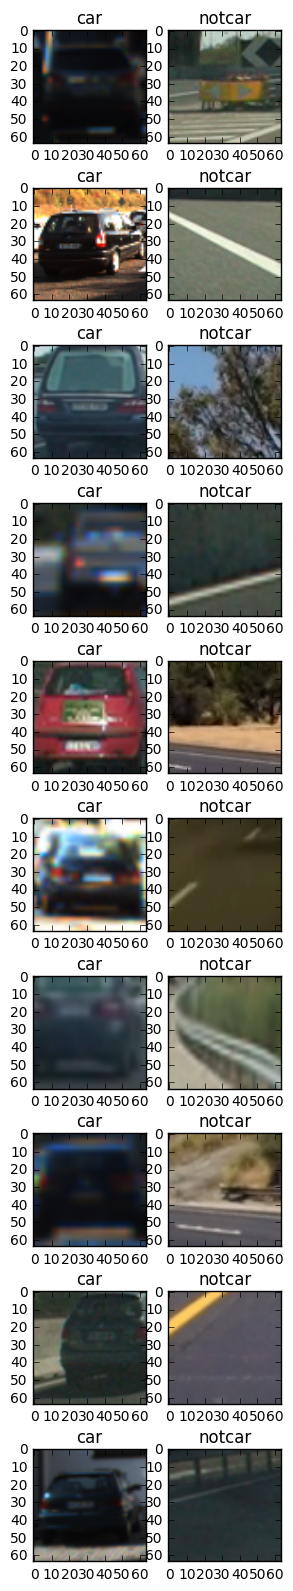

In [156]:
car_ind = np.random.randint(0, len(cars), size=(1,10))
notcar_ind = np.random.randint(0, len(notcars), size=(1,10))

imgs = []
titles = []

for i in range(10):
    car_img = mpimg.imread(cars[car_ind[0][i]])
    notcar_img = mpimg.imread(notcars[notcar_ind[0][i]])
    imgs.append(car_img)
    imgs.append(notcar_img)
    titles.extend(('car', 'notcar'))

# images = [car_img, car_hog_image, notcar_img, notcar_hog_image]
# titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']

fig = plt.figure(figsize=(3.2,20))
visualize(fig, 10, 2, imgs, titles)

## HOG Features Visualization

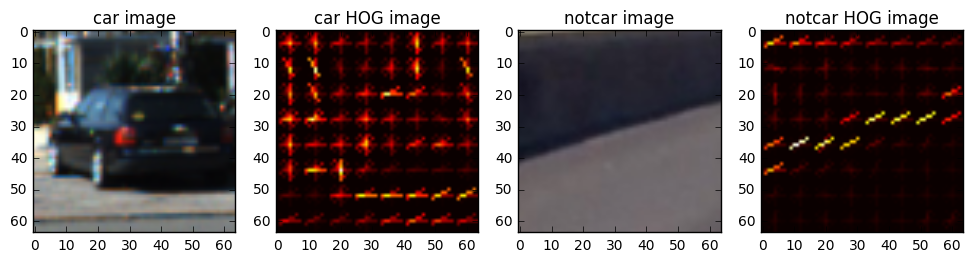

In [157]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_img = mpimg.imread(cars[car_ind])
notcar_img = mpimg.imread(notcars[notcar_ind])

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_img, color_space=color_space, 
                                                  spatial_size=spatial_size,
                                                  hist_bins=hist_bins,
                                                  orient=orient,
                                                  pix_per_cell=pix_per_cell,
                                                  cell_per_block=cell_per_block,
                                                  hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat,
                                                  hist_feat=hist_feat,
                                                  hog_feat=hog_feat,
                                                  vis=True)    
car_features, notcar_hog_image = single_img_features(notcar_img, color_space=color_space, 
                                                  spatial_size=spatial_size,
                                                  hist_bins=hist_bins,
                                                  orient=orient,
                                                  pix_per_cell=pix_per_cell,
                                                  cell_per_block=cell_per_block,
                                                  hog_channel=hog_channel,
                                                  spatial_feat=spatial_feat,
                                                  hist_feat=hist_feat,
                                                  hog_feat=hog_feat,
                                                  vis=True)
images = [car_img, car_hog_image, notcar_img, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [158]:
# Reduce the sample size if needed for testing
sample_size = None  # set to None to use all the data
if sample_size:
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

## Setting the parameters

In [159]:
global color_space, orient, pix_per_cell, cell_per_block, hog_channel
global spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, y_start_stop

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [11]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

## Training/Testing Data Splitting

In [12]:
# Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=89)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## Train a SVM Classifier

In [13]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

42.13 Seconds to train SVC...


## Evaluation

In [14]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
print(round(time.time()-t2, 2), 'Seconds to test SVC...')

Test Accuracy of SVC =  0.9938
0.16 Seconds to test SVC...


## Save the Model

In [15]:
from sklearn.externals import joblib
joblib.dump(svc, 'model_svc.pkl')
print('Saved model to disk')

Saved model to disk


In [160]:
svc = joblib.load('model_svc.pkl')

In [161]:
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Build a Vehicle Detection Pipeline

In [162]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 4)
    # Return the image
    return img

In [163]:
## applying HOG on each window
def vehicle_detecting(img_orig):
   
    draw_image = np.copy(img_orig)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = img_orig.astype(np.float32)/255

    y_start_stop = [400, 656] # Min and max in y to search in slide_window()
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.9, 0.8))
    
#     y_start_stop = [400, 550]
#     windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(160, 160), xy_overlap=(0.8, 0.6))
#     y_start_stop = [360, 650]
#     windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(220, 220), xy_overlap=(0.8, 0.5))
    
#     windows = windows1 + windows2 + windows3
    
    
    hot_windows = search_windows(image, windows1, svc, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
    
    print(len(hot_windows))
#     print(hot_windows)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    
   
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(window_img), labels)      
    
    return draw_img

## Pipeline on Test Images

In [164]:
# Read in the original image
img_orig = mpimg.imread('./test_images/test3.jpg')
# Prepare the canvas for drawing
img_draw = np.copy(img_orig)

scale = 2
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

img = img_orig.astype(np.float32)/255

img_scaled = cv2.resize(img, None, fx=1/scale, fy=1/scale)

y_start_stop_scaled = [int(y_start_stop[0]//scale), int(y_start_stop[1]//scale)]

windows = slide_window(img_scaled, x_start_stop=[None, None], y_start_stop=y_start_stop_scaled, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

# scale = 2
# y_start_stop = [400, 656] # Min and max in y to search in slide_window()

# img = img_orig.astype(np.float32)/255

# img_scaled = cv2.resize(img, None, fx=1/scale, fy=1/scale)

# y_start_stop_scaled = [int(y_start_stop[0]//scale), int(y_start_stop[1]//scale)]

# windows_ = slide_window(img_scaled, x_start_stop=[None, None], y_start_stop=y_start_stop_scaled, 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5))

# windows.extend(windows_)

img_scaled.shape, y_start_stop_scaled, img_scaled[0:5,0,0]

((360, 640, 3),
 [200, 328],
 array([ 0.58627456,  0.51764709,  0.47450981,  0.45294118,  0.44705883], dtype=float32))

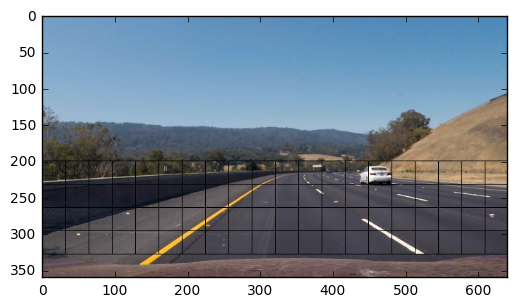

In [165]:
img_temp = draw_boxes(img_scaled, windows, color=(0, 0, 255), thick=1)   
plt.imshow(img_temp)

In [166]:
## applying HOG on a whole frame
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows_on_frame(img, windows,
                            clf, scaler, color_space='RGB', 
                            spatial_size=(32, 32), hist_bins=32, 
                            hist_range=(0, 256), orient=9, 
                            pix_per_cell=8, cell_per_block=2, 
                            hog_channel=0, spatial_feat=True, 
                            hist_feat=True, hog_feat=True,
                            scale=1, y_start_stop=None):
    
    

    #1) Create an empty list to receive positive detection windows
    on_windows = []    
    
    # Extract HOG features just once for the entire region of interest in each full image / video frame
    img_roi = img[y_start_stop[0]:y_start_stop[1],:,:]
    frame_hog_features = single_frame_features(img_roi, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=False, 
                                    hist_feat=False, hog_feat=True)
#     frame_hog_features = np.concatenate(frame_hog_features)
    
#     print('frame_hog_feature.shape: {}'.format(frame_hog_features.shape))
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_frame_features()
        features = single_frame_features(test_img, color_space=color_space, 
                                            spatial_size=spatial_size, hist_bins=hist_bins, 
                                            orient=orient, pix_per_cell=pix_per_cell, 
                                            cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                            hist_feat=hist_feat, hog_feat=False)
        
#         print('features shape: {}'.format(features.shape))
        
        win_y_start = round((window[0][1]-y_start_stop[0])/8)
        win_x_start = round((window[0][0]-0)/8)
        win_y_span = 7 #int((window[1][1]-window[0][1])/8)-2/2
        win_x_span = 7 #int((window[1][0]-window[0][0])/8)-2/2
        win_y_end = int(win_y_start + win_y_span)
        win_x_end = int(win_x_start + win_x_span)
#         print(win_y_span, win_x_span)
#         print(type(win_x_start), type(win_x_end))
#         print(win_x_start, win_x_end)
        if hog_channel == 'ALL':
            
            window_hog_features = []
            hog_step = frame_hog_features.shape[0]/3
#             print(hog_step)
            for channel in range(img.shape[2]):
                window_hog_features.extend((frame_hog_features[int(win_y_start+channel*hog_step):int(win_y_end+channel*hog_step),
                                                              win_x_start:win_x_end,:,:,:]).ravel()) 
                
#                 print('win hog features len: C{}, {}'.format(channel, len(window_hog_features)))
        else:
            window_hog_features.extend(frame_hog_features[win_y_start:win_y_end,win_x_start:win_x_end,:,:,:].ravel())
        
#         print((frame_hog_features[win_y_start:win_y_end,win_x_start:win_x_end,:,:,:]).shape)
        
#         print('len of window_hog_features: {}'.format(len(window_hog_features)))
        
        frame_features = []
        frame_features.append(features)        
        frame_features.append(window_hog_features)
        
        frame_features = np.concatenate(frame_features)
        
        
        temp_features = np.zeros([8460])
        temp_features[0:frame_features.shape[0]] = frame_features
        
#         print('frame_features.shape: {}'.format(temp_features.shape))
        
        #5) Scale extracted features to be fed to classifier
        
        
        
        test_features = scaler.transform(np.array(temp_features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:

            on_windows.append( ((int(window[0][0]*scale), int(window[0][1]*scale)),
                                (int(window[1][0]*scale), int(window[1][1]*scale))) )
    #8) Return windows for positive detections
    return on_windows

In [167]:
# Let's double check the parameters
print(color_space, spatial_size, hist_bins, orient, pix_per_cell,cell_per_block,hog_channel, spatial_feat,hist_feat,hog_feat)
print(scale, y_start_stop_scaled)

YCrCb (32, 32) 32 9 8 2 ALL True True True
2 [200, 328]


In [168]:
hot_windows = search_windows_on_frame(img_scaled, windows, 
                                      svc, X_scaler, color_space=color_space, 
                                      spatial_size=spatial_size, hist_bins=hist_bins, 
                                      orient=orient, pix_per_cell=pix_per_cell,
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, hog_feat=hog_feat,
                                      scale=scale, y_start_stop=y_start_stop_scaled)

In [169]:
hot_windows

[]

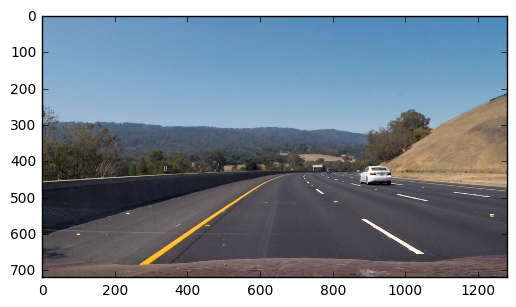

In [170]:
img_temp = draw_boxes(img_orig, hot_windows, color=(0, 0, 255), thick=2)   
plt.imshow(img_temp)

In [171]:
def search_resized(img_orig, scale=1.5, y_start_stop=[400,656]): 
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img_orig.astype(np.float32)/255

    img_scaled = cv2.resize(img, None, fx=1/scale, fy=1/scale)

    y_start_stop_scaled = [int(y_start_stop[0]//scale), int(y_start_stop[1]//scale)]

    windows = slide_window(img_scaled, x_start_stop=[None, None], y_start_stop=y_start_stop_scaled, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    

    hot_windows = search_windows_on_frame(img_scaled, windows, 
                                      svc, X_scaler, color_space=color_space, 
                                      spatial_size=spatial_size, hist_bins=hist_bins, 
                                      orient=orient, pix_per_cell=pix_per_cell,
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, hog_feat=hog_feat,
                                      scale=scale, y_start_stop=y_start_stop_scaled)
    
    return hot_windows

In [172]:

def average_heatmaps(heatmaps):
    if len(heatmaps)<10:
        return heatmaps[-1]
    else:
        heatmap_add = np.zeros_like(heatmaps[0])
        for heatmap in heatmaps[-10:]:
            heatmap_add += heatmap
        return heatmap_add

In [178]:
def find_car(img_orig):        
   
    draw_image = np.copy(img_orig)
    
    hot_windows = search_resized(img_orig, scale=1.5, y_start_stop=[400,656])
    hot_windows_ = search_resized(img_orig, scale=2, y_start_stop=[400,656])
    
    hot_windows.extend(hot_windows_)
#     hot_windows.extend(hot_windows__)
    
#     print(len(hot_windows))
#     print(hot_windows)
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    
   
    
    heat = np.zeros_like(img_orig[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
#     heat = apply_threshold(heat,0)
    hm.heatmaps.append(heat)
    
    # heatmap of each frame
    heatmap = average_heatmaps(hm.heatmaps)
    
    if len(hm.heatmaps)>=10:
        heatmap = apply_threshold(heatmap, 5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # Visualize the hot windows in blue rectangles
    DEBUG = True
    
    if DEBUG:
        draw_img = draw_labeled_bboxes(np.copy(window_img), labels)  
    else:
        draw_img = draw_labeled_bboxes(np.copy(img_orig), labels) 
        
    return draw_img


0.77 Seconds to implement a sliding-window searching


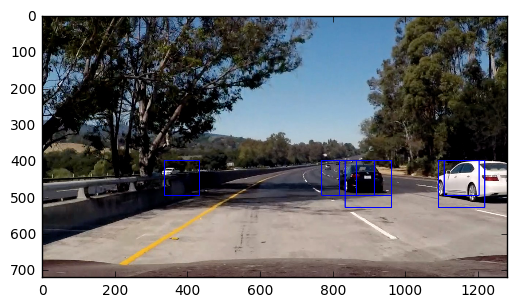

In [177]:
### Test the pipeline on a image
img_orig = mpimg.imread('./test_images/test5.jpg')

t = time.time()
hm = Heatmaps()
img_output = find_car(img_orig)
print()
print(round(time.time()-t, 2), 'Seconds to implement a sliding-window searching')

plt.imshow(img_output)

In [179]:
## Test the pipeline on the list of images
test_files = 'test_images/test*.jpg'
images = glob.glob(test_files)

imgs_for_vis = []
imgs_titles = []
for fname in images:
    img_orig = cv2.imread(fname)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    hm = Heatmaps()
    img_output = find_car(img_orig)
    imgs_for_vis.append(img_output)
    imgs_for_vis.append(hm.heatmaps[-1])
    imgs_titles.append(fname)
    imgs_titles.append('Heatmap of '+ fname)

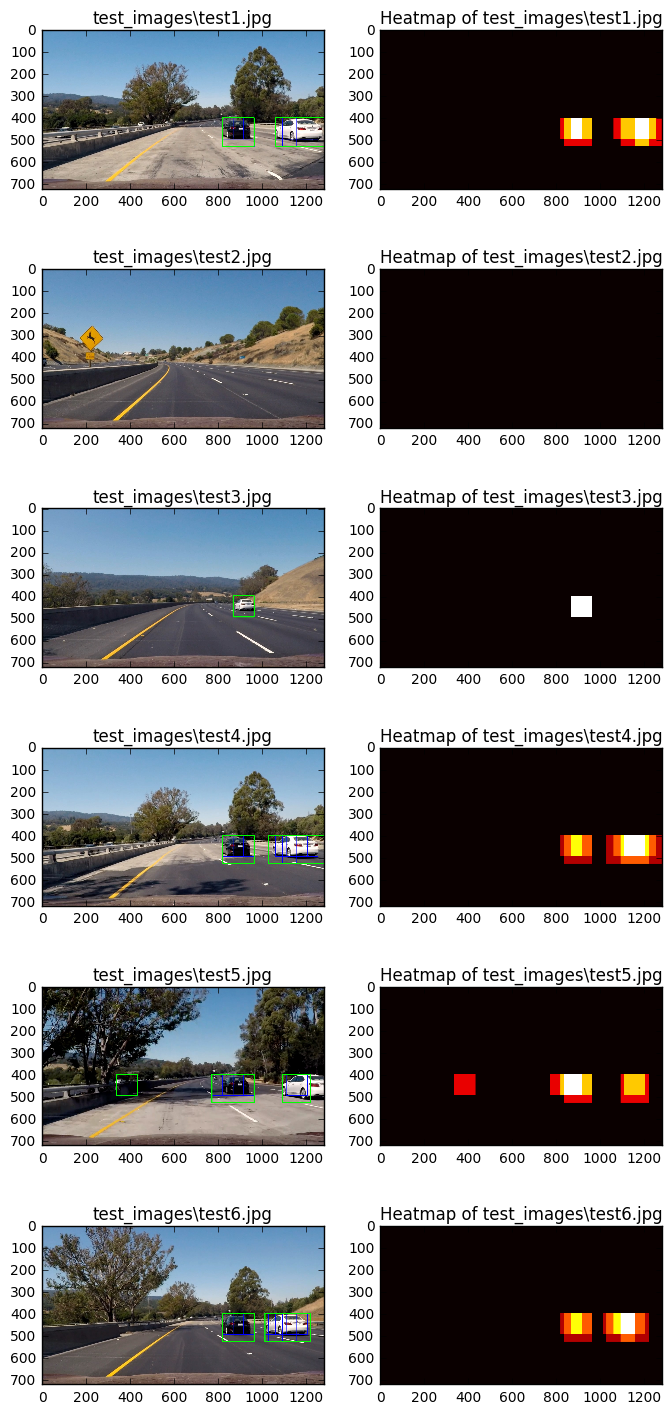

In [118]:
fig = plt.figure(figsize=(8,18))
visualize(fig, 6, 2, imgs_for_vis, imgs_titles)

## Video Implementation

In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [103]:
clip = VideoFileClip('test_video.mp4')
hm = Heatmaps()
video_clip = clip.fl_image(find_car) #NOTE: this function expects color images!!
%time video_clip.write_videofile('P5_test_output_try5.mp4', audio=False)

[MoviePy] >>>> Building video P5_test_output_try4.mp4
[MoviePy] Writing video P5_test_output_try4.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:36<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_test_output_try4.mp4 

Wall time: 37.7 s


In [53]:
len(hm.heatmaps)

39